In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Embedding, Add
from keras.layers import Conv1D, GlobalAveragePooling1D, AveragePooling2D, MaxPooling2D, MaxPool1D, ZeroPadding1D, GlobalMaxPooling2D, GlobalAveragePooling2D, LSTM, SpatialDropout1D
from keras.models import Sequential, Model
from keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.layers.merge import concatenate

In [3]:
import time
from datetime import timedelta
start_time = time.monotonic()

In [4]:
mit_test_data = pd.read_csv('data/mitbih_test.csv', header=None)
mit_train_data = pd.read_csv('data/mitbih_train.csv', header=None)

In [5]:
mit_train_data[187]=mit_train_data[187].astype(int)
equilibre=mit_train_data[187].value_counts()
print(equilibre)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


In [6]:
from sklearn.utils import resample
df_1=mit_train_data[mit_train_data[187]==1]
df_2=mit_train_data[mit_train_data[187]==2]
df_3=mit_train_data[mit_train_data[187]==3]
df_4=mit_train_data[mit_train_data[187]==4]
df_0=(mit_train_data[mit_train_data[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

mit_train_data=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [7]:
equilibre=mit_train_data[187].value_counts()
print(equilibre)

4    20000
3    20000
2    20000
1    20000
0    20000
Name: 187, dtype: int64


In [8]:
from tensorflow.keras.utils import to_categorical
X, y = mit_train_data.iloc[: , :-1], mit_train_data.iloc[: , -1]
X, valX, y, valy= train_test_split(X,y,test_size=0.2)
testX, testy = mit_test_data.iloc[: , :-1], mit_test_data.iloc[: , -1]
y = to_categorical(y)
testy = to_categorical(testy)
valy=to_categorical(valy)

In [9]:
print("X shape=" +str(X.shape))
print("y shape=" +str(y.shape))
print("valX shape=" +str(valX.shape))
print("valy shape=" +str(valy.shape))
print("testX shape=" +str(testX.shape))
print("testy shape=" +str(testy.shape))

X shape=(80000, 187)
y shape=(80000, 5)
valX shape=(20000, 187)
valy shape=(20000, 5)
testX shape=(21892, 187)
testy shape=(21892, 5)


In [10]:
from sklearn.utils import shuffle
mit_train_data[187] = mit_train_data[187].astype('int32')
mit_test_data[187] = mit_test_data[187].astype('int32')
X_train = np.array(mit_train_data.iloc[:, :187])
X_test = np.array(mit_test_data.iloc[:, :187])
y_train = np.array(mit_train_data[187])
y_test = np.array(mit_test_data[187])
X_train, y_train = shuffle(X_train, y_train, random_state = 101)
X_test, y_test = shuffle(X_test, y_test, random_state = 101)
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100000, 187, 1)
(21892, 187, 1)
(100000, 5)
(21892, 5)


# Alexnet

In [11]:
alexNet_model=Sequential()

alexNet_model.add(Conv1D(filters=96, activation='relu', kernel_size=11, strides=4, input_shape=(187,1)))
alexNet_model.add(BatchNormalization())
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=384, padding='same', kernel_size=3, activation='relu'))
alexNet_model.add(Conv1D(filters=384, kernel_size=3, activation='relu'))
alexNet_model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Flatten())
alexNet_model.add(Dense(4096, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(4096, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(5, activation='softmax'))

In [12]:
alexNet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 45, 96)            1152      
_________________________________________________________________
batch_normalization (BatchNo (None, 45, 96)            384       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 23, 96)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 23, 256)           123136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 256)           1024      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 12, 384)           2

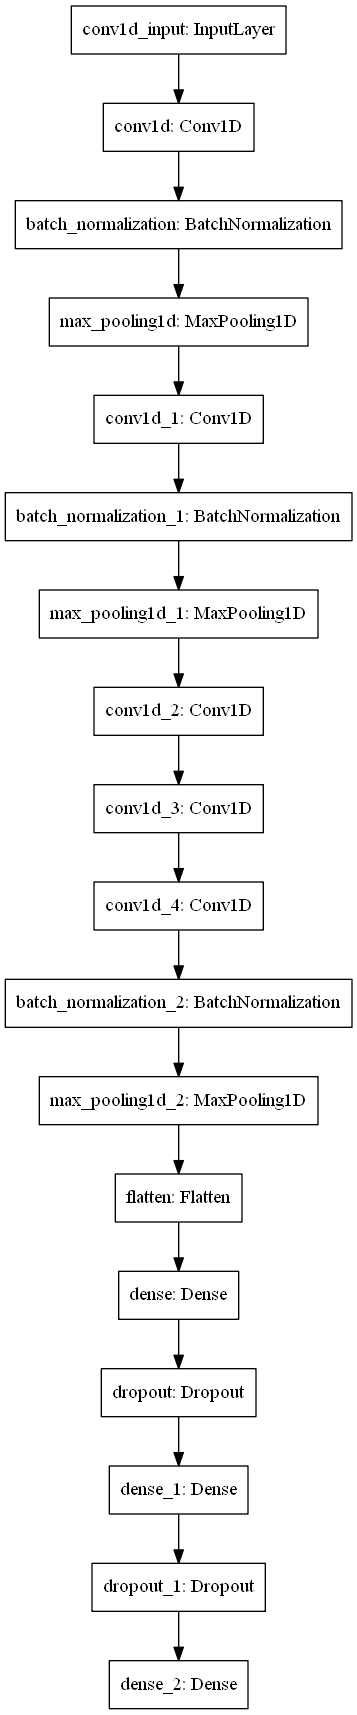

In [13]:
plot_model(alexNet_model)

In [14]:
alexNet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
alexNet_model_history = alexNet_model.fit(X_train, y_train, epochs = 20, batch_size = 100, validation_data = (X_test, y_test))

Epoch 1/20
1000/1000 [==============================] - 193s 193ms/step - loss: 0.3018 - accuracy: 0.8992 - val_loss: 0.3503 - val_accuracy: 0.8689
Epoch 2/20
1000/1000 [==============================] - 198s 198ms/step - loss: 0.1289 - accuracy: 0.9561 - val_loss: 0.2237 - val_accuracy: 0.9198
Epoch 3/20
1000/1000 [==============================] - 196s 196ms/step - loss: 0.0950 - accuracy: 0.9689 - val_loss: 0.1229 - val_accuracy: 0.9595
Epoch 4/20
1000/1000 [==============================] - 198s 198ms/step - loss: 0.0771 - accuracy: 0.9756 - val_loss: 0.1045 - val_accuracy: 0.9718
Epoch 5/20
1000/1000 [==============================] - 199s 199ms/step - loss: 0.0615 - accuracy: 0.9805 - val_loss: 0.1643 - val_accuracy: 0.9538
Epoch 6/20
1000/1000 [==============================] - 196s 196ms/step - loss: 0.0550 - accuracy: 0.9835 - val_loss: 0.1261 - val_accuracy: 0.9699
Epoch 7/20
1000/1000 [==============================] - 197s 197ms/step - loss: 0.0502 - accuracy: 0.9848 - val_

Text(0, 0.5, 'Accuracy')

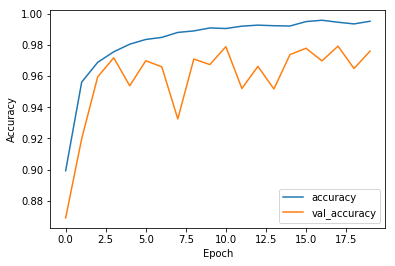

In [16]:
plt.plot(alexNet_model_history.history['accuracy'])
plt.plot(alexNet_model_history.history['val_accuracy'])
plt.legend(["accuracy","val_accuracy"])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

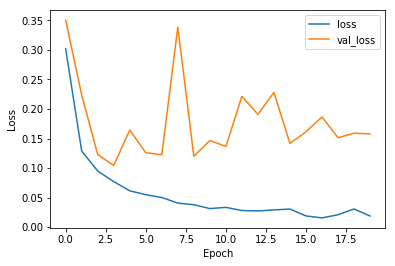

In [17]:
plt.plot(alexNet_model_history.history['loss'])
plt.plot(alexNet_model_history.history['val_loss'])
plt.legend(["loss","val_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [18]:
y_true=[]
for element in y_test:
    y_true.append(np.argmax(element))
prediction_proba=alexNet_model.predict(X_test)
prediction=np.argmax(prediction_proba,axis=1)

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
print(classification_report(y_true,prediction))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     18118
           1       0.73      0.85      0.79       556
           2       0.90      0.96      0.93      1448
           3       0.68      0.86      0.76       162
           4       0.98      0.99      0.99      1608

   micro avg       0.98      0.98      0.98     21892
   macro avg       0.86      0.93      0.89     21892
weighted avg       0.98      0.98      0.98     21892



In [20]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true, prediction)

0.08866252512333272

In [21]:
def evaluate_model(alexNet_model_history,testX,testy,history):
    scores = model.evaluate((testX),testy, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(alexNet_model_history.history['accuracy'])
    plt.plot(alexNet_model_history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(alexNet_model_history.history['loss'])
    plt.plot(alexNet_model_history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(testX)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    

Normalized confusion matrix


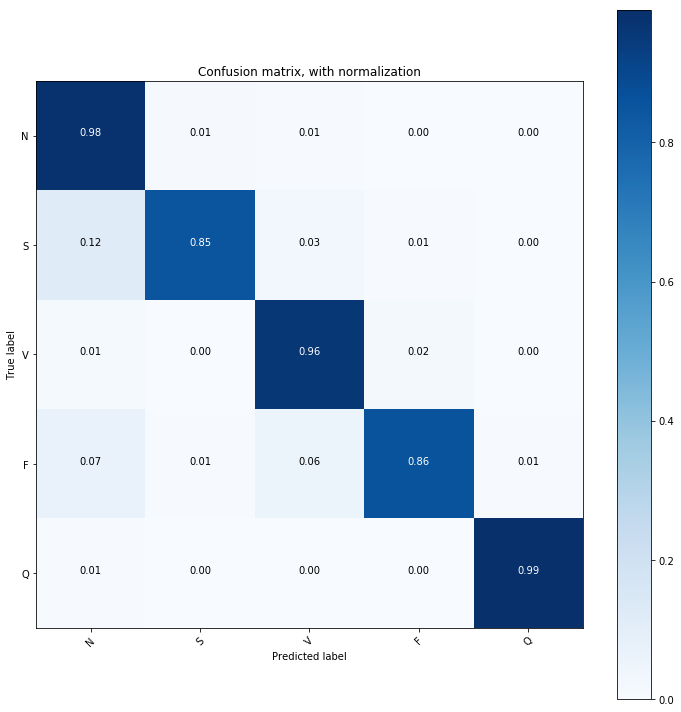

In [22]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()



In [23]:
end_time = time.monotonic()
print(timedelta(seconds=end_time - start_time))

1:11:23.219000
